In [11]:
!pip install jax jaxlib

In [12]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jax import grad, vmap
import jax
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import arviz as az
import pymc as pm
import pytensor.tensor as pt

In [2]:
np.random.seed(42)

In [13]:
## SVGD Core (JAX)
def rbf_kernel_jax(x):
    n, d = x.shape
    pairwise_dists = jnp.sum((x[:, None] - x[None, :])**2, axis=-1)
    h = jnp.median(pairwise_dists) / jnp.log(n + 1.0)
    K = jnp.exp(-pairwise_dists / h)
    return K, h

def svgd_update_jax(particles, log_prob_fn, steps=100, lr=1e-2):
    history = [particles]
    n_particles = particles.shape[0]
    grad_logp = vmap(grad(log_prob_fn))

    for i in range(steps):
        Kxy, h = rbf_kernel_jax(particles)
        grad_log_p = grad_logp(particles)

        def phi(i):
            diff = particles[i] - particles
            kernel_grad = jnp.sum(Kxy[i][:, None] * (-2 * diff / h), axis=0)
            return (Kxy[i] @ grad_log_p + kernel_grad) / n_particles

        phi_v = vmap(phi)(jnp.arange(n_particles))
        particles += lr * phi_v
        if i % 20 == 0:
            history.append(particles)
    return particles, history##

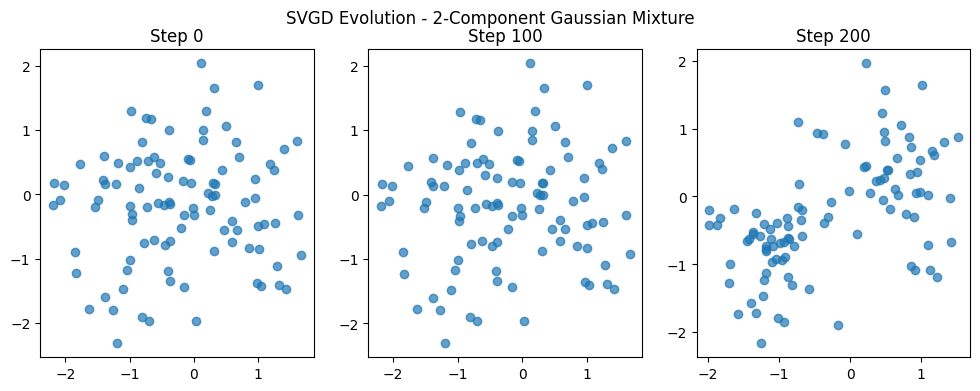

In [14]:
# ---- Test 1: 2-Component Gaussian Mixture ---- #
def log_prob_mixture_jax(x):
    mean1 = jnp.array([2.0, 2.0])
    mean2 = jnp.array([-2.0, -2.0])
    lp1 = -0.5 * jnp.sum((x - mean1)**2)
    lp2 = -0.5 * jnp.sum((x - mean2)**2)
    return jax.scipy.special.logsumexp(jnp.array([lp1, lp2]))

init_particles = jnp.array(np.random.randn(100, 2))
final_particles_mix, history_mix = svgd_update_jax(init_particles, log_prob_mixture_jax, steps=300, lr=0.1)

# Plot Particle Evolution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    part = np.array(history_mix[i])
    ax.scatter(part[:, 0], part[:, 1], alpha=0.7)
    ax.set_title(f'Step {i * (300//3)}')
plt.suptitle("SVGD Evolution - 2-Component Gaussian Mixture")
plt.show()

### Explanation

- This is a visualization of particles (points) evolving over time under SVGD.
- Each scatter plot shows the state of the particles at different time steps during optimization.
- Step 0
  - This is the initial state.
  - All particles are sampled from a standard normal distribution centered around 0.
  - The particles are randomly scattered and haven’t learned anything about the target distribution yet.
- Step 100
  - The particles have started to feel the shape of the true distribution.
  - You can see some early clustering starting to happen.
  - The two modes of the 2-component Gaussian mixture are beginning to influence the particle movements.
- Step 200
  - Two distinct clusters have formed, roughly around [-2, -2] and [2, 2].
  - This shows that SVGD successfully approximated the posterior, which is a bimodal (two-peak) distribution.
  - The particles now represent samples from the true distribution.
- SVGD turns a set of random particles into structured samples from a complex distribution (here, 2 Gaussians). It uses functional gradient descent with a kernel to repulse similar particles and attract them toward high-probability regions.

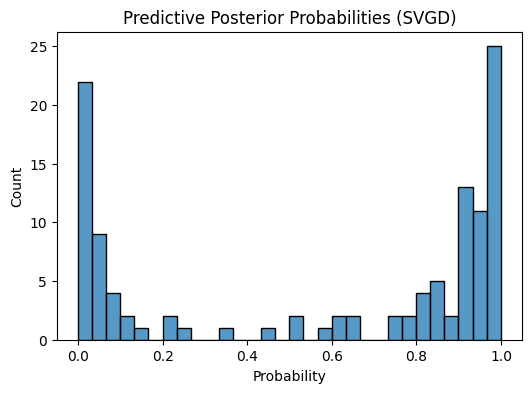

In [15]:
# ---- Test 2: Bayesian Logistic Regression ---- #
data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)

def log_posterior_jax(w):
    logits = X_train_jax @ w
    log_lik = jnp.sum(y_train_jax * logits - jnp.logaddexp(0, logits))
    log_prior = -0.5 * jnp.sum(w**2)
    return log_lik + log_prior

init_weights = jnp.array(np.random.randn(100, X_train.shape[1]))
w_final, _ = svgd_update_jax(init_weights, log_posterior_jax, steps=500, lr=1e-3)

# Predictive posterior
X_test_jax = jnp.array(X_test)
logits = X_test_jax @ w_final.T
probs = jax.nn.sigmoid(logits)
mean_probs = np.array(probs.mean(axis=1))

plt.figure(figsize=(6, 4))
sns.histplot(mean_probs, bins=30)
plt.title("Predictive Posterior Probabilities (SVGD)")
plt.xlabel("Probability")
plt.show()

### Explanation

- Each bar represents how many test samples got a certain predicted probability of being in class 1 (malignant tumor). These probabilities are based on SVGD particles sampling the posterior over model weights.
- The x-axis is the predicted probability (from 0 to 1), and the y-axis is the number of test examples predicted with that probability.
- There are two peaks - near 0.0 and 0.1.
- The model is generally very confident in its predictions — most outputs are near 0 or 1.
- Very few test samples are predicted with uncertain probabilities (e.g., between 0.4 and 0.6).
- This histogram reflects Bayesian averaging — the probabilities come from many weight samples (particles).
- Instead of a single deterministic prediction, we get a distribution of predictions across different posterior samples.
- The Bayesian logistic regression model fits the data well. There's relatively low model uncertainty for most samples.

Output()

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


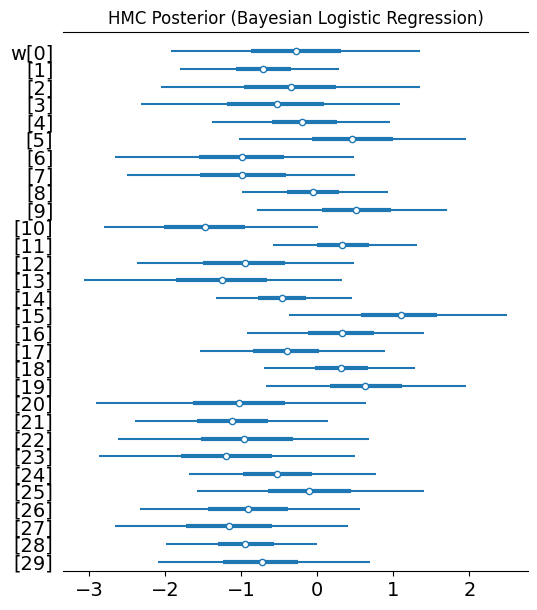

In [16]:
# ---- HMC Comparison (PyMC) ---- #
with pm.Model() as logistic_model:
    w = pm.Normal('w', mu=0, sigma=1, shape=X_train.shape[1])
    logits = pm.math.dot(X_train, w)
    y_obs = pm.Bernoulli('y', logit_p=logits, observed=y_train)
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

az.plot_forest(trace, var_names=["w"], combined=True)
plt.title("HMC Posterior (Bayesian Logistic Regression)")
plt.show()

### Explanation

- Each row corresponds to a parameter w[i] in the Bayesian logistic regression model (i.e., weight for one input feature).
- The horizontal lines are credible intervals (posterior uncertainty) for each parameter. The white dots are the posterior means of the parameters.
- This is the result of using Hamiltonian Monte Carlo (HMC) to sample from the posterior distribution.
- There are 30 weights (features in the dataset). Each weight's posterior mean (white dot) tells us the average effect of that feature on the prediction.
- The length of the horizontal bars represents how uncertain we are about each weight. The short bars represent very high confidence (that means low uncertainity).
- If a weight’s interval is mostly to the right of 0, it positively contributes to predicting class 1 (malignant). If it’s mostly to the left of 0, it negatively contributes (leans toward predicting class 0 / benign).
- This visualization gives insights into feature importance and posterior uncertainty.